In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## Imports

In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler

## Data

In [3]:
# Get the data from .csv file.
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
# Extract training data.
y = train["label"].values
X = train.drop("label", axis=1).values
# Extract test data.
X_test = test.values
# Reshape images.
X = X.reshape(-1, 28, 28, 1).astype("float") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype("float") / 255.0
# Split data into training set and validation set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Plot random examples

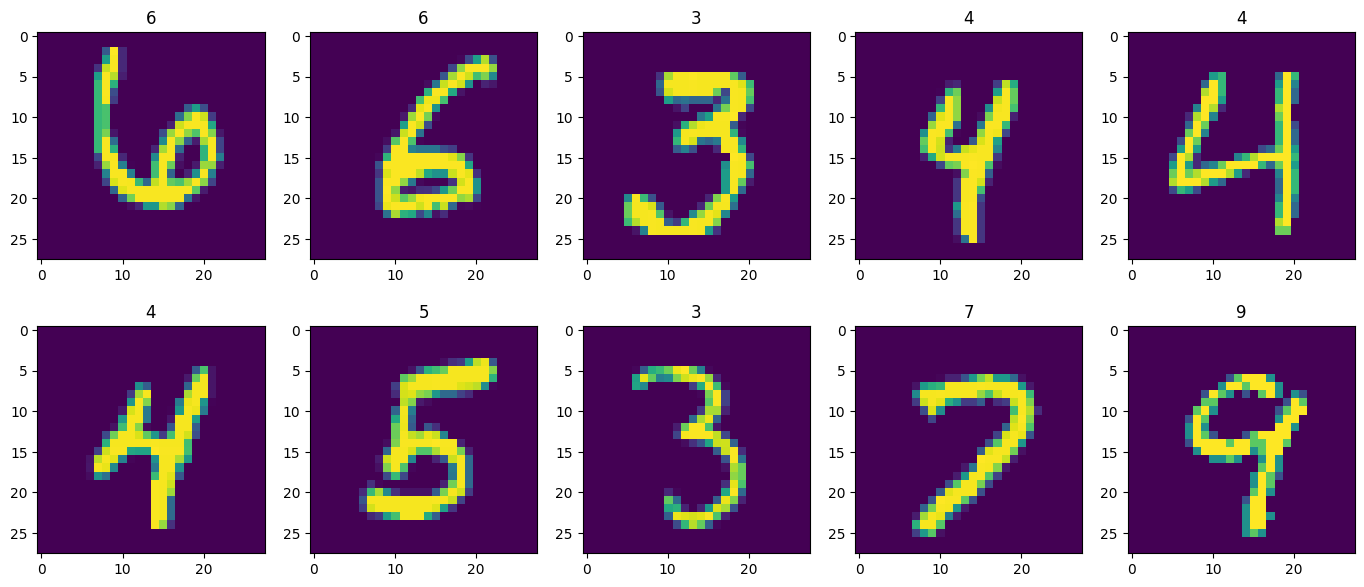

In [4]:
# Subplots.
fig, axs = plt.subplots(nrows=2, ncols=5)
# Set figure dimensions.
fig.set_figwidth(17)
fig.set_figheight(7)
# Iterate axes.
for ax in axs.reshape(-1):
    # Show random image from training set.
    index = np.random.randint(0, y_train.size)
    ax.imshow(X_train[index])
    ax.set_title(y_train[index])

## Model

### Build the model

In [5]:
# Create model.
model = Sequential([
    # Convolutional layers.
    Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation=relu),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation=relu),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation=relu),
    # Flatten output.
    Flatten(),
    # Dense layers.
    Dense(units=64, activation=relu),
    Dense(units=10, activation=linear)
])
# Compile.
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=AdamW(),
    metrics=["accuracy"]
)
# Show model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          16448     
                                                                 
 flatten (Flatten)           (None, 1024)              0

### Define learing rate scheduler

In [6]:
def lr_schedule(epoch):
    lr = 0.001
    # From epoch 5 decrease learning rate
    # by factor 10.
    if epoch > 3: lr *= 0.1
    return lr

### Train model

In [7]:
# Learning rate scheduler.
lr_scheduler = LearningRateScheduler(lr_schedule)
# Train model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=6,
    callbacks=[lr_scheduler]
)

Epoch 1/6
1050/1050 [==============================] - 24s 21ms/step - loss: 0.1954 - accuracy: 0.9402 - val_loss: 0.0860 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 2/6
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0577 - accuracy: 0.9818 - val_loss: 0.0469 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 3/6
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0416 - accuracy: 0.9866 - val_loss: 0.0417 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 4/6
1050/1050 [==============================] - 21s 20ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.0398 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 5/6
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0286 - val_accuracy: 0.9911 - lr: 1.0000e-04
Epoch 6/6
1050/1050 [==============================] - 22s 21ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.0280 - val_accuracy: 0.9910 - lr: 1.0000e-04


## Evaluation

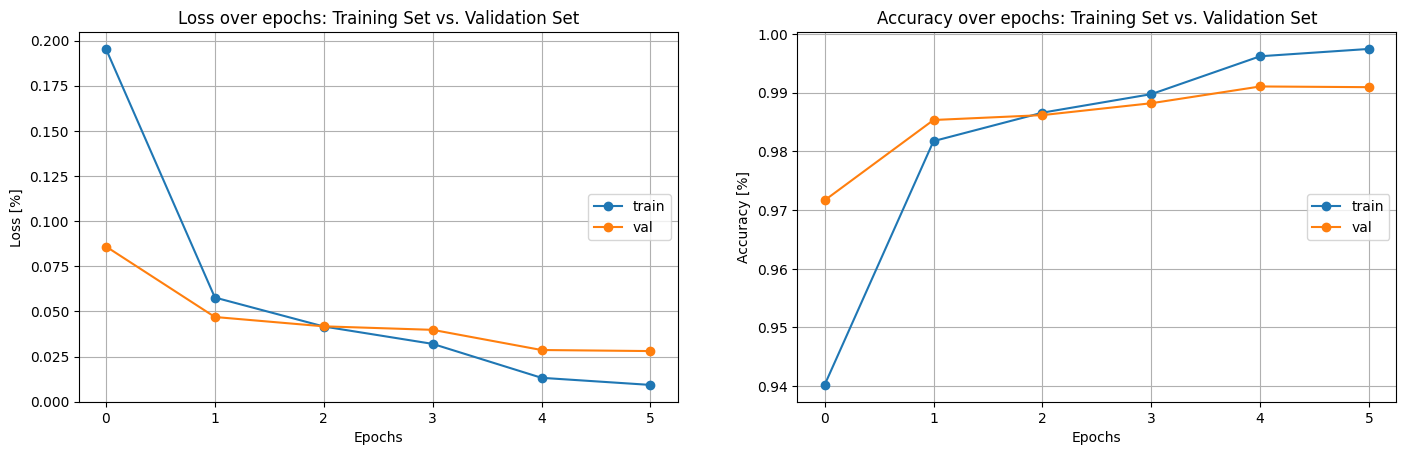

In [11]:
# Subplots.
fig, (ax1, ax2) = plt.subplots(1, 2)
# Set figure dimensions.
fig.set_figwidth(17)
# Plot losses of training set and validation set.
ax1.plot(history.history["loss"], marker="o")
ax1.plot(history.history["val_loss"], marker="o")
# Plot accurancy of training set and validation set.
ax2.plot(history.history["accuracy"], marker="o")
ax2.plot(history.history["val_accuracy"], marker="o")
# Add grids.
ax1.grid()
ax2.grid()
# Set labels.
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax1.set_ylabel("Loss [%]")
ax2.set_ylabel("Accuracy [%]")
# Set titles.
ax1.set_title("Loss over epochs: Training Set vs. Validation Set")
ax2.set_title("Accuracy over epochs: Training Set vs. Validation Set")
# Add legends.
ax1.legend(["train", "val"], loc="center right")
ax2.legend(["train", "val"], loc="center right")
# Render figure.
plt.show()

## Testing

In [9]:
# Get predictions.
test_predictions =  model.predict(X_test)
# Transform to dataframe.
predicted_labels = np.argmax(test_predictions, axis=1)
submission_df = pd.DataFrame({'ImageId': range(1, len(predicted_labels) + 1), 'Label': predicted_labels})
# Save as .csv file.
submission_df.to_csv('submission.csv', index=False)

875/875 [==============================] - 6s 6ms/step
